In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb


In [3]:
df = pd.read_csv('../raw_data/sales_train.csv', parse_dates=['date'])

/var/folders/jd/69j4d5lx4s9dg3b1d0bfcxx80000gp/T/ipykernel_11144/838203109.py:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df = pd.read_csv('../raw_data/sales_train.csv', parse_dates=['date'])


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date            datetime64[ns]
 1   date_block_num  int64         
 2   shop_id         int64         
 3   item_id         int64         
 4   item_price      float64       
 5   item_cnt_day    float64       
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB


In [8]:
def sales_days(df, time=["daily", 'monthly','yearly']):
    df= df.copy()
    if time == "daily":
        df.date= df.date.apply(lambda x: str(x)[:-9])
    elif time == "monthly":
    
        df.date= df.date.apply(lambda x: str(x)[:-12])
    else:
        df.date= df.date.apply(lambda x: str(x)[:4])
        
   
    df= df.groupby('date')['item_cnt_day'].sum().reset_index()
    df.date= pd.to_datetime(df.date)
        
    return df

In [9]:
df_day= sales_days(df, "daily")
df_day.head()

,date,item_cnt_day
0,2013-01-01,1951.0
1,2013-01-02,3817.0
2,2013-01-03,3846.0
3,2013-01-04,2574.0
4,2013-01-05,4863.0


In [10]:
df_month=sales_days(df,'monthly')
df_month.head()

,date,item_cnt_day
0,2013-01-01,116950.0
1,2013-02-01,133607.0
2,2013-03-01,140586.0
3,2013-04-01,112185.0
4,2013-05-01,116808.0


In [12]:
df_year= sales_days(df, "yearly")
df_year.head()

,date,item_cnt_day
0,2013-01-01,1562733.0
1,2014-01-01,1320889.0
2,2015-01-01,764584.0


In [13]:
df_day= df_day.set_index('date')

<AxesSubplot: xlabel='date'>

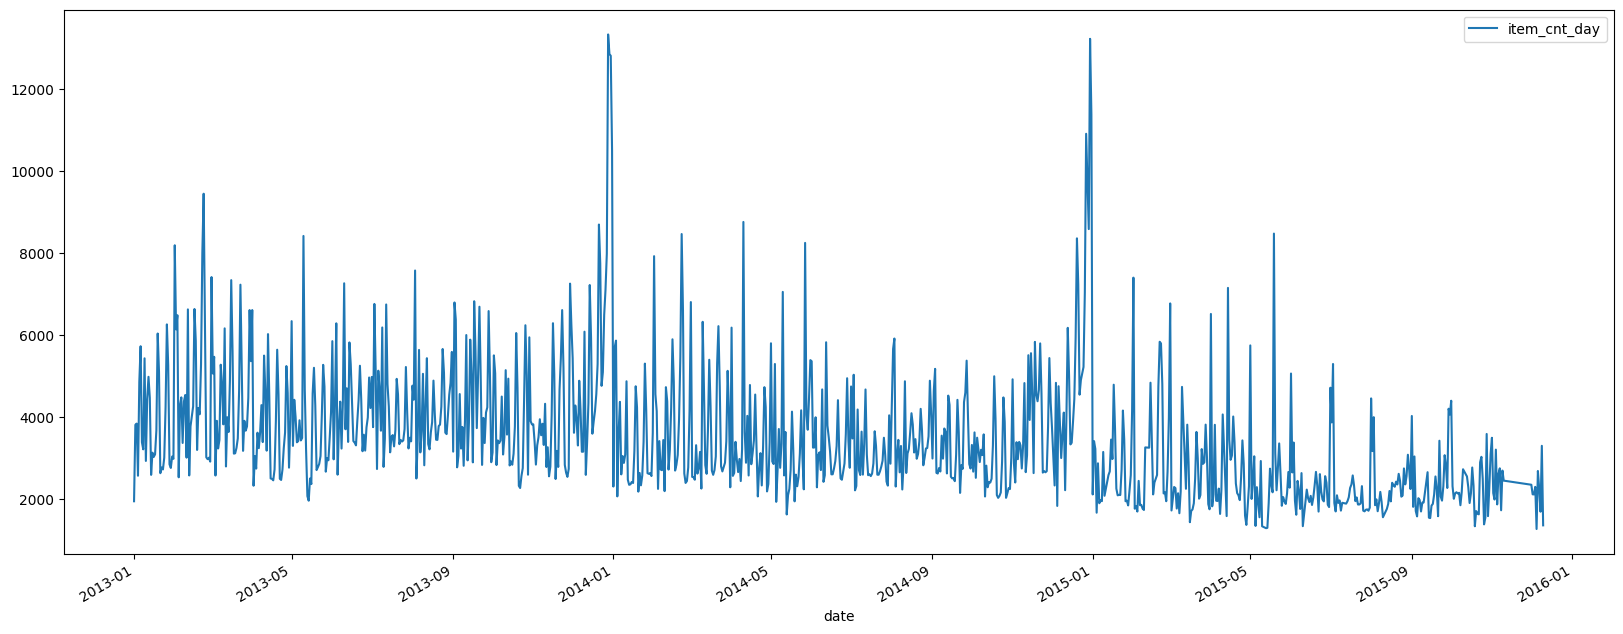

In [14]:
df_day.plot(figsize=(20, 8))

In [18]:
def create_date_time_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    #df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week.astype("int64")
    return df

In [21]:
df_model = create_date_time_features(df_day)
df_model

,item_cnt_day,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
date,,,,,,,,
2013-01-01,1951.0,1,1,1,2013,1,1,1
2013-01-02,3817.0,2,1,1,2013,2,2,1
2013-01-03,3846.0,3,1,1,2013,3,3,1
2013-01-04,2574.0,4,1,1,2013,4,4,1
2013-01-05,4863.0,5,1,1,2013,5,5,1
...,...,...,...,...,...,...,...,...
2015-12-06,2690.0,6,4,12,2015,340,6,49
2015-12-07,2263.0,0,4,12,2015,341,7,50
2015-12-08,1696.0,1,4,12,2015,342,8,50


In [22]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1034 entries, 2013-01-01 to 2015-12-10
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   item_cnt_day  1034 non-null   float64
 1   dayofweek     1034 non-null   int64  
 2   quarter       1034 non-null   int64  
 3   month         1034 non-null   int64  
 4   year          1034 non-null   int64  
 5   dayofyear     1034 non-null   int64  
 6   dayofmonth    1034 non-null   int64  
 7   weekofyear    1034 non-null   int64  
dtypes: float64(1), int64(7)
memory usage: 72.7 KB


In [23]:
#defining train and test data 
train= df_model.loc[df_model.index < '2015-01-01']
test = df_model.loc[df_model.index >= '2015-01-01']

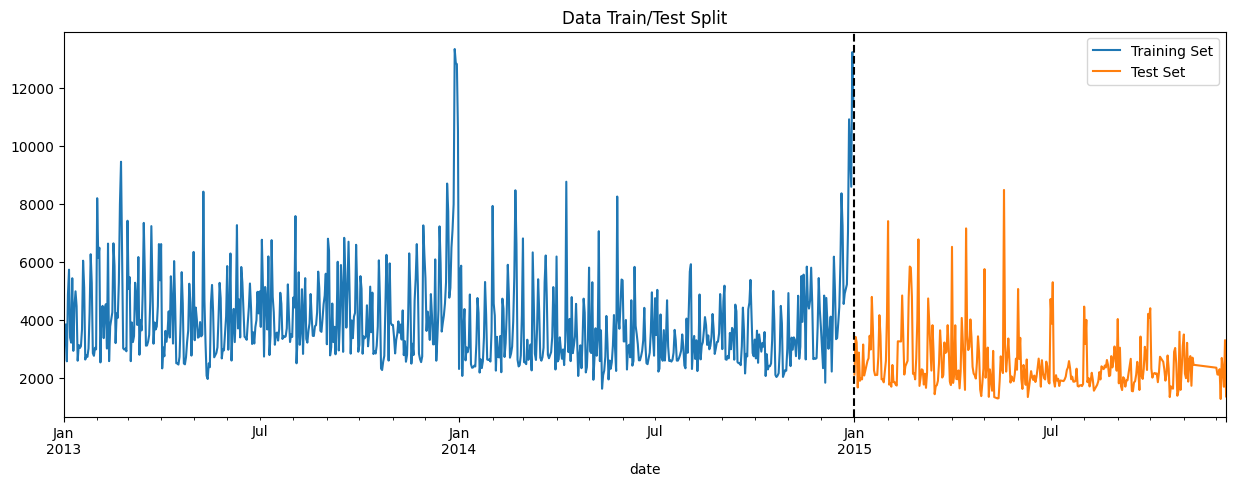

In [24]:
fig, ax = plt.subplots(figsize=(15, 5))
df_day.loc[df_day.index < '2015-01-01'].plot(ax=ax, label='Training Set', title='Data Train/Test Split')
df_day.loc[df_day.index >= '2015-01-01'].plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [25]:
df_model.columns

Index(['item_cnt_day', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear',
       'dayofmonth', 'weekofyear'],
      dtype='object')

In [28]:
FEATURES = ['dayofweek', 'quarter', 'month', 'year', 'dayofyear',
       'dayofmonth', 'weekofyear']

TARGET = 'item_cnt_day'

In [29]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [32]:
model= xgb.XGBRegressor(random_state=1)

In [39]:
model.fit(X_train, y_train,
          eval_set=[(X_train, y_train), (X_test, y_test)],
          verbose=100)

y_pred = model.predict(y_test)

[0]	validation_0-rmse:3104.15641	validation_1-rmse:1768.10488
[99]	validation_0-rmse:113.14230	validation_1-rmse:1298.78812


ValueError: training data did not have the following fields: dayofweek, quarter, month, year, dayofyear, dayofmonth, weekofyear

In [38]:
y_test

date
2015-01-01    2117.0
2015-01-02    3418.0
2015-01-03    3229.0
2015-01-04    1672.0
2015-01-05    2877.0
               ...  
2015-12-06    2690.0
2015-12-07    2263.0
2015-12-08    1696.0
2015-12-09    3304.0
2015-12-10    1363.0
Name: item_cnt_day, Length: 304, dtype: float64

In [5]:
data_raw['id_final'] = data_raw.apply(lambda x: (f"{x['shop_id']}-{x['item_id']}"), axis=1)

In [64]:
df = data_raw[['date','id_final','item_cnt_day', 'date_block_num']]

In [65]:
df = df.rename(columns={'date': 'ds', 'item_cnt_day':'y'})

In [66]:
df.head()

,ds,id_final,y,date_block_num
109593,2013-01-01,46-18616,1.0,0
85162,2013-01-01,54-11854,1.0,0
18128,2013-01-01,28-4906,1.0,0
112216,2013-01-01,42-2931,1.0,0
85141,2013-01-01,54-11604,1.0,0


Running Prophet test

In [9]:
key_groups = df.groupby('id_final')

In [10]:
id_list = key_groups.groups.keys()

In [60]:
id_list_2 = df.head(1000).id_final.tolist()

In [61]:
len(id_list_2)

1000

In [62]:
#making predictions 
def train_and_forecast(group):
        
    #defining model
    model = Prophet()

    #fitting model 
    model.fit(group)

    #making predictions
    future = model.make_future_dataframe(periods=30)
    forecast = model.predict(future)[['ds','yhat']]
    forecast['id_final'] = group['id_final'].iloc(0)

    #results
    return forecast[['ds','id_final','yhat']]


In [63]:
#loop forecast
for_loop_forecast = pd.DataFrame()

#looping 
for id_final in id_list_2:

    group = key_groups.get_group(id_final)
    if len(group)>2:
        
        forecast = train_and_forecast(group)
        for_loop_forecast = pd.concat((for_loop_forecast,forecast))
    


16:22:34 - cmdstanpy - INFO - Chain [1] start processing
16:22:34 - cmdstanpy - INFO - Chain [1] done processing
16:22:35 - cmdstanpy - INFO - Chain [1] start processing
16:22:35 - cmdstanpy - INFO - Chain [1] done processing
16:22:36 - cmdstanpy - INFO - Chain [1] start processing
16:22:36 - cmdstanpy - INFO - Chain [1] done processing
16:22:40 - cmdstanpy - INFO - Chain [1] start processing
16:22:40 - cmdstanpy - INFO - Chain [1] done processing
16:22:41 - cmdstanpy - INFO - Chain [1] start processing
16:22:41 - cmdstanpy - INFO - Chain [1] done processing
16:22:41 - cmdstanpy - INFO - Chain [1] start processing
16:22:41 - cmdstanpy - INFO - Chain [1] done processing
16:22:42 - cmdstanpy - INFO - Chain [1] start processing
16:22:43 - cmdstanpy - INFO - Chain [1] done processing
16:22:44 - cmdstanpy - INFO - Chain [1] start processing
16:22:44 - cmdstanpy - INFO - Chain [1] done processing
16:22:44 - cmdstanpy - INFO - Chain [1] start processing
16:22:45 - cmdstanpy - INFO - Chain [1]

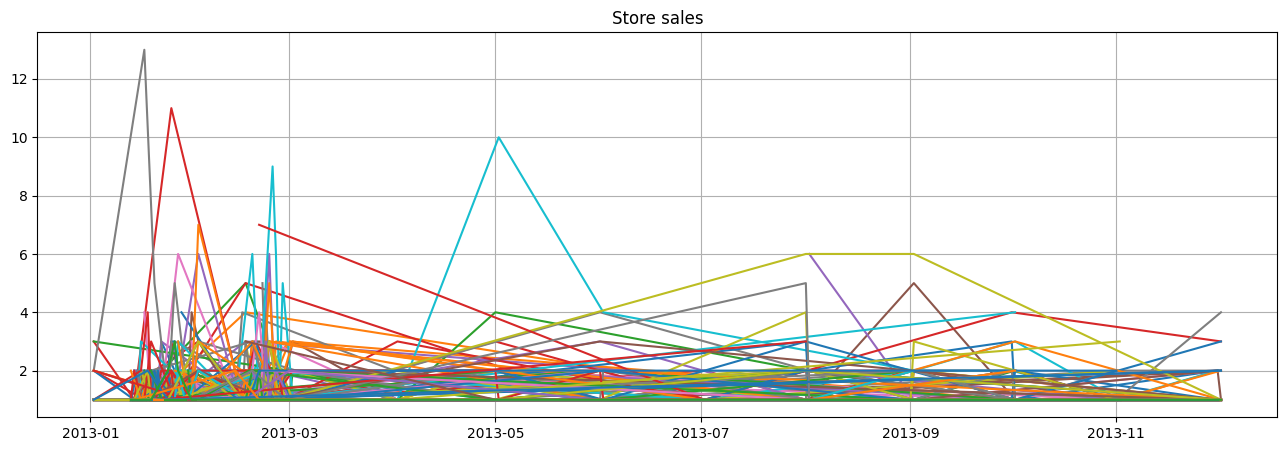

In [5]:
plt.subplots(1, figsize=(16,5))
plt.grid()
plt.title('Store sales')
for item in set(data_raw[data_raw['shop_id'] == 1]['item_id']):
         plt.plot(data_raw[(data_raw['shop_id'] == 1) &
                  (data_raw['item_id'] == item)]['item_cnt_day'])

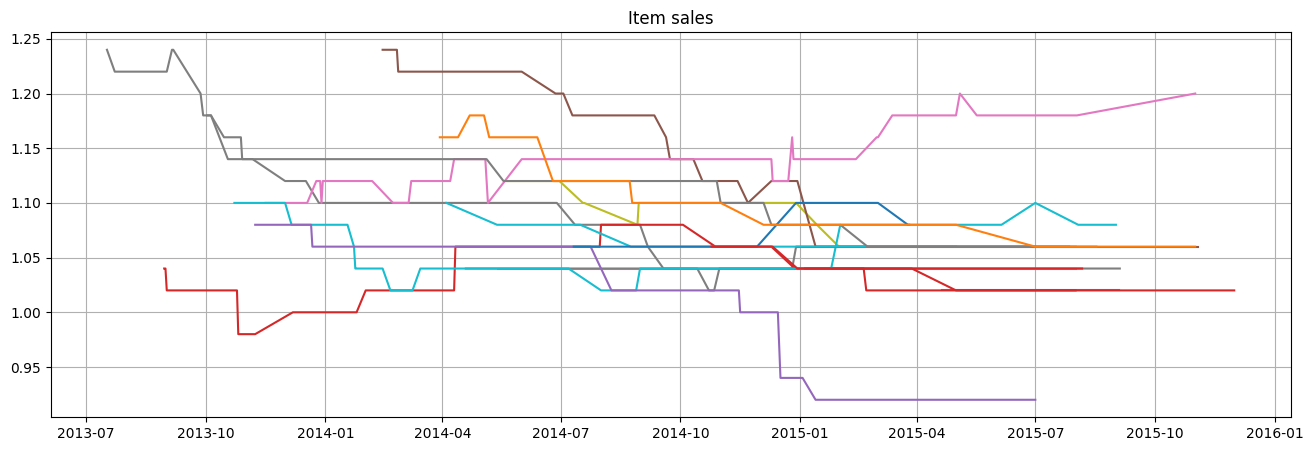

In [6]:
plt.subplots(1, figsize=(16,5))
plt.grid()
plt.title('Item sales')
for store in set(data_raw[data_raw['item_id'] == 4906]['shop_id']):
         plt.plot(data_raw[(data_raw['item_id'] == 4906) &
                  (data_raw['shop_id'] == store)]['item_cnt_day'].rolling(window=50).mean())

In [7]:
prophet_basic = Prophet()

TypeError: 'module' object is not callable

In [7]:
train_dataset = data_raw[(data_raw['item_id'] == 1) & data_raw['shop_id'] == 1]
train_dataset.reset_index(level=0, inplace=True)
train_dataset = train_dataset[['date','item_cnt_day']]
train_dataset.columns = ['ds','y']

prophet_basic = Prophet()
prophet_basic.fit(train_dataset)

TypeError: 'module' object is not callable